In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num = 1, block_size = 1, total_size = None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit = 'B', unit_scale = True, miniters = 1, desc = dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

In [2]:
import collections
import numpy as np
import random
data_index = 0

def build_dataset(words, vocabulary_size):
    count = []
    count.extend(collections.Counter(words).most_common(vocabulary_size))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = []
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        data.append(index)
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, reverse_dictionary

def generate_batch_skipgram(words, batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    for i in range(span):
        buffer.append(words[data_index])
        data_index = (data_index + 1) % len(words)
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(words[data_index])
        data_index = (data_index + 1) % len(words)
    data_index = (data_index + len(words) - span) % len(words)
    return batch, labels

In [3]:
import tensorflow as tf

class Model:
    
    def __init__(self, batch_size, dimension_size, learning_rate, vocabulary_size):
        
        self.train_inputs = tf.placeholder(tf.int32, shape = [batch_size])
        self.train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, dimension_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, self.train_inputs)
        self.nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, dimension_size], 
                                                           stddev = 1.0 / np.sqrt(dimension_size)))
        self.nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        self.loss = tf.reduce_mean(tf.nn.nce_loss(weights = self.nce_weights, biases = self.nce_biases, 
                                                  labels = self.train_labels,inputs=embed, 
                                                  num_sampled = batch_size / 2, num_classes = vocabulary_size))
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        self.normalized_embeddings = embeddings / norm

In [4]:
DIMENSION = 128
BATCH_SIZE = 128
SKIP_WINDOW = 1
NUM_SKIP = 2
EPOCH = 20000
words_real = text.split()

In [5]:
print("Data size:", len(words_real))
data, _, dictionary = build_dataset(words_real, len(set(words_real)))
print("Vocabulary size:", len(dictionary))

Data size: 17005207
Vocabulary size: 253854


In [6]:
import time
sess = tf.InteractiveSession()
print("Creating Word2Vec model..")
    
model = Model(BATCH_SIZE, DIMENSION, 1.0, len(dictionary))
sess.run(tf.global_variables_initializer())

for step in range(EPOCH):
    last_time = time.time()
    batch_inputs, batch_labels = generate_batch_skipgram(data, BATCH_SIZE, NUM_SKIP, SKIP_WINDOW)
    feed_dict = {model.train_inputs: batch_inputs, model.train_labels: batch_labels}
        
    _, loss = sess.run([model.optimizer, model.loss], feed_dict=feed_dict)
        
    if ((step + 1) % 1000) == 0:
        diff = time.time() - last_time
        print("epoch:", step + 1, ", loss: ", loss, ", speed: ", diff, " s / epoch")

Creating Word2Vec model..
epoch: 1000 , loss:  184.531 , speed:  0.0012159347534179688  s / epoch
epoch: 2000 , loss:  186.794 , speed:  0.001232147216796875  s / epoch
epoch: 3000 , loss:  201.294 , speed:  0.0012595653533935547  s / epoch
epoch: 4000 , loss:  113.262 , speed:  0.0012459754943847656  s / epoch
epoch: 5000 , loss:  115.654 , speed:  0.002288341522216797  s / epoch
epoch: 6000 , loss:  67.9849 , speed:  0.0013518333435058594  s / epoch
epoch: 7000 , loss:  77.0094 , speed:  0.0012128353118896484  s / epoch
epoch: 8000 , loss:  60.8115 , speed:  0.001214742660522461  s / epoch
epoch: 9000 , loss:  80.6634 , speed:  0.0012640953063964844  s / epoch
epoch: 10000 , loss:  139.142 , speed:  0.0012106895446777344  s / epoch
epoch: 11000 , loss:  55.5825 , speed:  0.0012214183807373047  s / epoch
epoch: 12000 , loss:  107.621 , speed:  0.0011739730834960938  s / epoch
epoch: 13000 , loss:  44.1218 , speed:  0.0012195110321044922  s / epoch
epoch: 14000 , loss:  72.0773 , speed

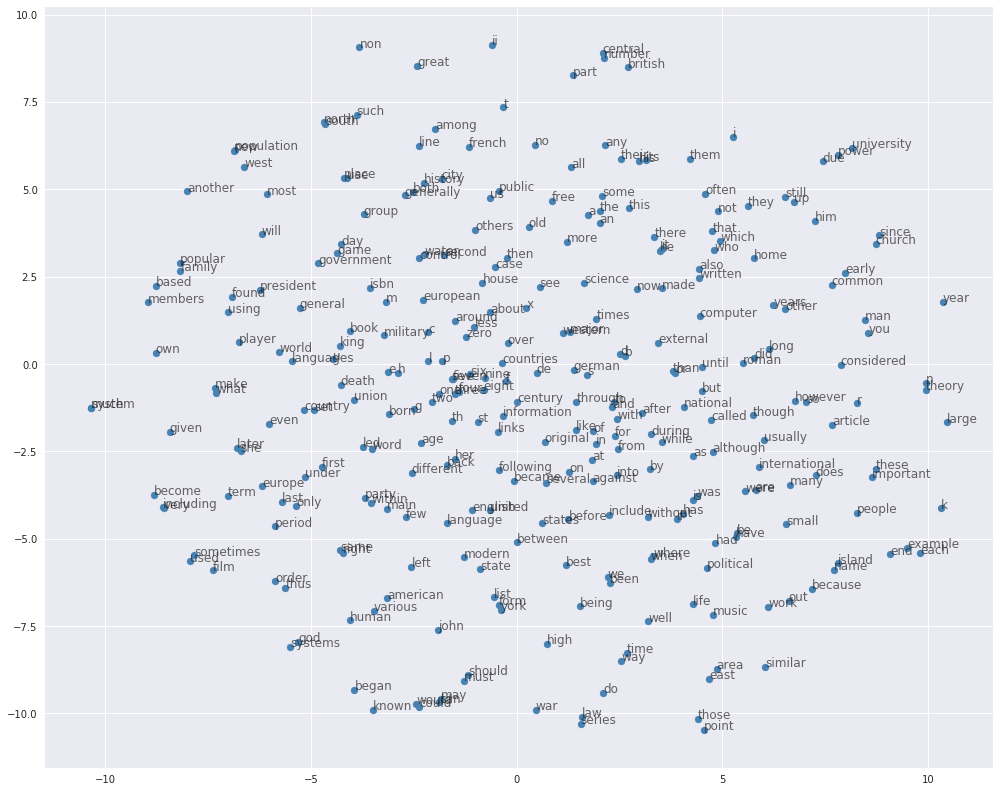

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
sns.set()

embed_mat = sess.run(model.normalized_embeddings)
embed_tsne = TSNE().fit_transform(embed_mat[:300, :])
labels = [dictionary[i] for i in range(300)]
fig, ax = plt.subplots(figsize = (17, 14))
for idx in range(300):
    plt.scatter(embed_tsne[idx, 0], embed_tsne[idx, 1], color = 'steelblue')
    plt.annotate(labels[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha = 0.7)
plt.show()

In [8]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(10, metric='cosine').fit(embed_mat)
random_selected = np.random.randint(0, len(dictionary))
xtest = embed_mat[random_selected, :].reshape((1,-1))
distances, indices = neighbors.kneighbors(xtest)
print("i selected:", dictionary[random_selected])

i selected: numerals


In [9]:
for no, i in enumerate(indices[0]):
    print('nearest k-%d: %s'%(no, dictionary[i]))

nearest k-0: numerals
nearest k-1: reginae
nearest k-2: regime
nearest k-3: colleges
nearest k-4: zero
nearest k-5: dasyprocta
nearest k-6: bodybuilders
nearest k-7: deposit
nearest k-8: electrophoresis
nearest k-9: agouti


In [10]:
random_selected = np.random.randint(0, len(dictionary))
xtest = embed_mat[random_selected, :].reshape((1,-1))
distances, indices = neighbors.kneighbors(xtest)
print("i selected:", dictionary[random_selected])
for no, i in enumerate(indices[0]):
    print('nearest k-%d: %s'%(no, dictionary[i]))

i selected: fennec
nearest k-0: fennec
nearest k-1: unchanged
nearest k-2: organon
nearest k-3: olier
nearest k-4: wellendorf
nearest k-5: filth
nearest k-6: turo
nearest k-7: cullen
nearest k-8: mesoamerican
nearest k-9: lite
